In [6]:
!pip install optuna

Using device: cpu
Iniciando Pipeline de Dados...
Divisão e Balanceamento concluídos.
--- Análise de Outliers (IQR) no Treino ---
Removendo total de 1014 registros...
Epoch 0 | Loss 0.7001 | KS 0.2544
Epoch 10 | Loss 0.5868 | KS 0.3929
Epoch 20 | Loss 0.5412 | KS 0.4439
Epoch 30 | Loss 0.5192 | KS 0.4826
Epoch 40 | Loss 0.5073 | KS 0.4919
Epoch 50 | Loss 0.4994 | KS 0.4957
Epoch 60 | Loss 0.4938 | KS 0.5073
Epoch 70 | Loss 0.4894 | KS 0.5089
Epoch 80 | Loss 0.4857 | KS 0.5112
Epoch 90 | Loss 0.4824 | KS 0.5058
Epoch 100 | Loss 0.4792 | KS 0.5043
KS Teste: 0.5574
AUC Teste: 0.8426


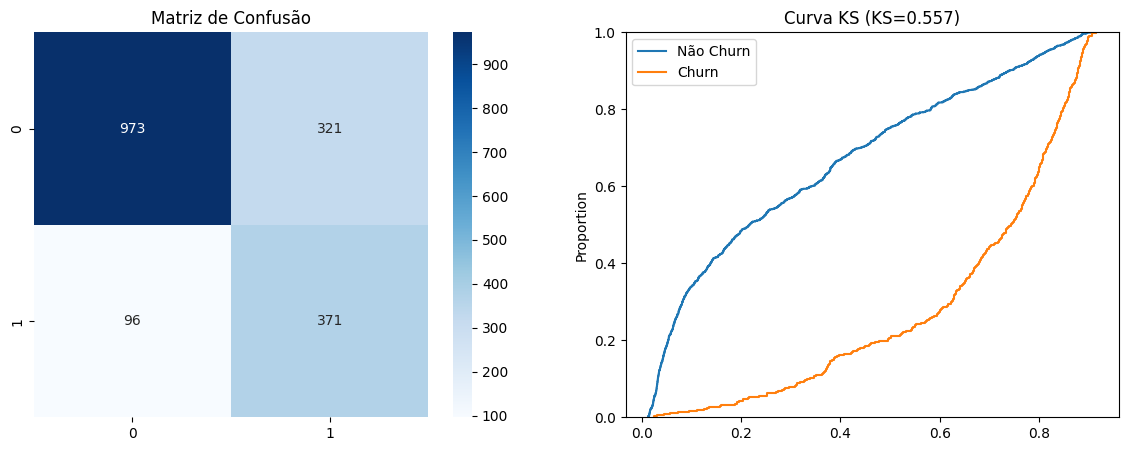

In [2]:
# =====================================================
# TabKAN REAL (Spline-based) para Churn Prediction
# Arquitetura fiel ao conceito Kolmogorov–Arnold Networks
# Métrica principal: KS
# =====================================================

# %%
# 1. Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns

# %%
# 2. Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# %%
# 3. Pré-processamento
from pre_processing import ChurnDataProcessor

processor = ChurnDataProcessor('customer_churn_telecom_services.csv')
(X_train_num, X_train_cat, y_train,
 X_val_num, X_val_cat, y_val,
 X_test_num, X_test_cat, y_test) = processor.run_pipeline()

# %%
# 4. Label Encoding categórico (seguro)
cat_cols = X_train_cat.columns
cat_cardinalities = []

for col in cat_cols:
    le = LabelEncoder()
    X_train_cat[col] = le.fit_transform(X_train_cat[col])
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    X_val_cat[col] = X_val_cat[col].map(mapping).fillna(0).astype(int)
    X_test_cat[col] = X_test_cat[col].map(mapping).fillna(0).astype(int)
    cat_cardinalities.append(len(le.classes_))

# %%
# 5. Tensores

def to_tensor(x, dtype):
    return torch.tensor(x.values if isinstance(x, (pd.DataFrame, pd.Series)) else x, dtype=dtype).to(device)

X_train_num_t = to_tensor(X_train_num, torch.float32)
X_val_num_t   = to_tensor(X_val_num, torch.float32)
X_test_num_t  = to_tensor(X_test_num, torch.float32)

X_train_cat_t = to_tensor(X_train_cat, torch.long)
X_val_cat_t   = to_tensor(X_val_cat, torch.long)
X_test_cat_t  = to_tensor(X_test_cat, torch.long)

y_train_t = to_tensor(y_train, torch.long)
y_val_t   = to_tensor(y_val, torch.long)
y_test_t  = to_tensor(y_test, torch.long)

num_features = X_train_num_t.shape[1]

# %%
# 6. KANLinear com B-Splines (KAN REAL)
class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.base_weight = nn.Parameter(torch.randn(out_features, in_features))
        self.spline_weight = nn.Parameter(torch.randn(out_features, in_features, grid_size))
        self.register_buffer('grid', torch.linspace(-1, 1, grid_size))

    def forward(self, x):
        x = torch.tanh(x)
        base = F.linear(x, self.base_weight)

        # spline part
        spline_out = 0
        for i in range(self.grid_size):
            spline_out += F.linear(x * self.grid[i], self.spline_weight[:, :, i])

        return base + spline_out

# %%
# 7. TabKAN Arquitetura Oficial
class TabKAN(nn.Module):
    def __init__(self, num_features, cat_cardinalities, embedding_dim, hidden_dims):
        super().__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(c, embedding_dim) for c in cat_cardinalities
        ])

        input_dim = num_features + len(cat_cardinalities) * embedding_dim

        layers = []
        in_dim = input_dim
        for h in hidden_dims:
            layers.append(KANLinear(in_dim, h))
            layers.append(nn.LayerNorm(h))
            in_dim = h

        self.kan_layers = nn.Sequential(*layers)
        self.out = nn.Linear(in_dim, 2)

    def forward(self, x_num, x_cat):
        emb = [emb_layer(x_cat[:, i]) for i, emb_layer in enumerate(self.embeddings)]
        x = torch.cat([x_num] + emb, dim=1)
        x = self.kan_layers(x)
        return self.out(x)

# %%
# 8. Trainer com Early Stopping por KS
class Trainer:
    def __init__(self, model, lr=1e-3):
        self.model = model.to(device)
        self.optim = torch.optim.AdamW(model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()

    def fit(self, epochs=300, patience=30):
        best_ks = -1
        patience_ctr = 0

        for epoch in range(epochs):
            self.model.train()
            self.optim.zero_grad()
            logits = self.model(X_train_num_t, X_train_cat_t)
            loss = self.criterion(logits, y_train_t)
            loss.backward()
            self.optim.step()

            self.model.eval()
            with torch.no_grad():
                val_logits = self.model(X_val_num_t, X_val_cat_t)
                probs = torch.softmax(val_logits, 1)[:, 1].cpu().numpy()
                y_np = y_val_t.cpu().numpy()
                ks = ks_2samp(probs[y_np == 0], probs[y_np == 1])[0]

            if ks > best_ks:
                best_ks = ks
                patience_ctr = 0
            else:
                patience_ctr += 1
                if patience_ctr >= patience:
                    break

            if epoch % 10 == 0:
                print(f"Epoch {epoch} | Loss {loss.item():.4f} | KS {ks:.4f}")

# %%
# 9. Treinamento Final
model = TabKAN(
    num_features=num_features,
    cat_cardinalities=cat_cardinalities,
    embedding_dim=8,
    hidden_dims=[64, 32]
)

trainer = Trainer(model, lr=1e-3)
trainer.fit()

# %%
# 10. Avaliação Teste
model.eval()
with torch.no_grad():
    logits = model(X_test_num_t, X_test_cat_t)
    probs = torch.softmax(logits, 1)[:, 1].cpu().numpy()

y_test_np = y_test_t.cpu().numpy()
ks = ks_2samp(probs[y_test_np == 0], probs[y_test_np == 1])[0]
auc = roc_auc_score(y_test_np, probs)

print(f"KS Teste: {ks:.4f}")
print(f"AUC Teste: {auc:.4f}")

# %%
# 11. Gráficos
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
cm = confusion_matrix(y_test_np, (probs >= 0.5).astype(int))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')

plt.subplot(1,2,2)
sns.ecdfplot(probs[y_test_np==0], label='Não Churn')
sns.ecdfplot(probs[y_test_np==1], label='Churn')
plt.title(f'Curva KS (KS={ks:.3f})')
plt.legend()
plt.show()


In [5]:
!pip install optuna
print("Optuna installed successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.7 MB/s eta 0:00:00
Optuna installed successfully.


In [7]:
import optuna

def objective(trial):
    # 3. Define the search space for hyperparameters
    embedding_dim = trial.suggest_int('embedding_dim', 4, 16)
    n_layers = trial.suggest_int('n_layers', 1, 3)

    hidden_dims = []
    for i in range(n_layers):
        hidden_dims.append(trial.suggest_categorical(f'n_neurons_l{i}', [32, 64, 128, 256]))

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    # 4. Create an instance of the TabKAN model with suggested hyperparameters
    model = TabKAN(
        num_features=num_features,
        cat_cardinalities=cat_cardinalities,
        embedding_dim=embedding_dim,
        hidden_dims=hidden_dims
    )

    # 5. Create an instance of the Trainer
    trainer = Trainer(model, lr=learning_rate)

    # 6. Train the model (simplified fit for Optuna to avoid long runs)
    # Using a shorter number of epochs and patience for trial runs
    trainer.fit(epochs=100, patience=10) # Reduced epochs and patience for faster trials

    # 7. Evaluate the trained model on the validation set for KS
    model.eval()
    with torch.no_grad():
        val_logits = model(X_val_num_t, X_val_cat_t)
        probs = torch.softmax(val_logits, 1)[:, 1].cpu().numpy()
        y_np = y_val_t.cpu().numpy()
        ks = ks_2samp(probs[y_np == 0], probs[y_np == 1])[0]

    # 8. Return the validation KS score
    return ks

print("Objective function 'objective' defined successfully.")

Objective function 'objective' defined successfully.


In [8]:
import optuna

# 12. Configurar e executar o estudo do Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Run 50 trials for hyperparameter optimization

print("Número de trials concluídos: ", len(study.trials))
print("Melhor trial:")
trial = study.best_trial

print(f"  Valor: {trial.value:.4f}")
print("  Hiperparâmetros:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-12-19 13:13:52,484] A new study created in memory with name: no-name-37769fb4-d219-44c7-b568-37a5574d6c34
/tmp/ipython-input-4225371889.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


Epoch 0 | Loss 0.7270 | KS 0.2506
Epoch 10 | Loss 0.5235 | KS 0.4996
Epoch 20 | Loss 0.4997 | KS 0.5189


[I 2025-12-19 13:14:02,767] Trial 0 finished with value: 0.5127610208816705 and parameters: {'embedding_dim': 8, 'n_layers': 3, 'n_neurons_l0': 256, 'n_neurons_l1': 128, 'n_neurons_l2': 32, 'learning_rate': 0.0016391205268731384}. Best is trial 0 with value: 0.5127610208816705.


Epoch 0 | Loss 0.7839 | KS 0.2367
Epoch 10 | Loss 0.5325 | KS 0.4934
Epoch 20 | Loss 0.5087 | KS 0.5112
Epoch 30 | Loss 0.5005 | KS 0.5267


[I 2025-12-19 13:14:03,830] Trial 1 finished with value: 0.51430781129157 and parameters: {'embedding_dim': 4, 'n_layers': 1, 'n_neurons_l0': 64, 'learning_rate': 0.005426796177908312}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.9599 | KS 0.3032


[I 2025-12-19 13:14:04,379] Trial 2 finished with value: 0.2907965970610982 and parameters: {'embedding_dim': 5, 'n_layers': 1, 'n_neurons_l0': 128, 'learning_rate': 2.8988424389504375e-05}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.7122 | KS 0.2444
Epoch 10 | Loss 0.6837 | KS 0.2815
Epoch 20 | Loss 0.6593 | KS 0.3241
Epoch 30 | Loss 0.6387 | KS 0.3844
Epoch 40 | Loss 0.6215 | KS 0.4339
Epoch 50 | Loss 0.6071 | KS 0.4594
Epoch 60 | Loss 0.5950 | KS 0.4695
Epoch 70 | Loss 0.5848 | KS 0.4733
Epoch 80 | Loss 0.5762 | KS 0.4818
Epoch 90 | Loss 0.5688 | KS 0.4872


[I 2025-12-19 13:14:08,844] Trial 3 finished with value: 0.48646558391337974 and parameters: {'embedding_dim': 4, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 64, 'learning_rate': 0.00012171471617061743}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.7195 | KS 0.1825
Epoch 10 | Loss 0.5312 | KS 0.4911
Epoch 20 | Loss 0.5039 | KS 0.5135
Epoch 30 | Loss 0.4966 | KS 0.5128


[I 2025-12-19 13:14:20,625] Trial 4 finished with value: 0.5088940448569219 and parameters: {'embedding_dim': 12, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 256, 'n_neurons_l2': 256, 'learning_rate': 0.00042329625929481726}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.7062 | KS 0.1090
Epoch 10 | Loss 0.6664 | KS 0.2660
Epoch 20 | Loss 0.6351 | KS 0.3527
Epoch 30 | Loss 0.6111 | KS 0.3944
Epoch 40 | Loss 0.5926 | KS 0.4184
Epoch 50 | Loss 0.5781 | KS 0.4393
Epoch 60 | Loss 0.5663 | KS 0.4563
Epoch 70 | Loss 0.5568 | KS 0.4640
Epoch 80 | Loss 0.5489 | KS 0.4756
Epoch 90 | Loss 0.5423 | KS 0.4872


[I 2025-12-19 13:14:26,896] Trial 5 finished with value: 0.4965197215777262 and parameters: {'embedding_dim': 4, 'n_layers': 1, 'n_neurons_l0': 256, 'learning_rate': 9.150259868730196e-05}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.6318 | KS 0.3449
Epoch 10 | Loss 0.5303 | KS 0.4733
Epoch 20 | Loss 0.5125 | KS 0.4919
Epoch 30 | Loss 0.5033 | KS 0.5012
Epoch 40 | Loss 0.4956 | KS 0.5104
Epoch 50 | Loss 0.4893 | KS 0.5135
Epoch 60 | Loss 0.4834 | KS 0.5151


[I 2025-12-19 13:14:39,986] Trial 6 finished with value: 0.5135344160866203 and parameters: {'embedding_dim': 7, 'n_layers': 2, 'n_neurons_l0': 256, 'n_neurons_l1': 128, 'learning_rate': 0.000804981215058518}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.7147 | KS 0.1315
Epoch 10 | Loss 0.6866 | KS 0.2019
Epoch 20 | Loss 0.6630 | KS 0.2568
Epoch 30 | Loss 0.6435 | KS 0.3155
Epoch 40 | Loss 0.6274 | KS 0.3527
Epoch 50 | Loss 0.6140 | KS 0.3782
Epoch 60 | Loss 0.6025 | KS 0.4068


[I 2025-12-19 13:14:47,961] Trial 7 finished with value: 0.4013921113689095 and parameters: {'embedding_dim': 14, 'n_layers': 3, 'n_neurons_l0': 64, 'n_neurons_l1': 128, 'n_neurons_l2': 32, 'learning_rate': 6.694403723654341e-05}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.9200 | KS 0.0967
Epoch 10 | Loss 0.5319 | KS 0.4888
Epoch 20 | Loss 0.5116 | KS 0.5019
Epoch 30 | Loss 0.4993 | KS 0.5050
Epoch 40 | Loss 0.4949 | KS 0.5073
Epoch 50 | Loss 0.4931 | KS 0.5135


[I 2025-12-19 13:14:52,293] Trial 8 finished with value: 0.5112142304717711 and parameters: {'embedding_dim': 14, 'n_layers': 1, 'n_neurons_l0': 64, 'learning_rate': 0.005934669109831068}. Best is trial 1 with value: 0.51430781129157.


Epoch 60 | Loss 0.4915 | KS 0.5104
Epoch 0 | Loss 0.6844 | KS 0.4517
Epoch 10 | Loss 0.5063 | KS 0.4981


[I 2025-12-19 13:14:53,740] Trial 9 finished with value: 0.5065738592420727 and parameters: {'embedding_dim': 13, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 128, 'learning_rate': 0.005686740842657}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.6817 | KS 0.2444
Epoch 10 | Loss 0.5393 | KS 0.4849
Epoch 20 | Loss 0.5093 | KS 0.4988
Epoch 30 | Loss 0.4996 | KS 0.5089


[I 2025-12-19 13:14:55,427] Trial 10 finished with value: 0.5112142304717711 and parameters: {'embedding_dim': 10, 'n_layers': 1, 'n_neurons_l0': 32, 'learning_rate': 0.0023784450868529435}. Best is trial 1 with value: 0.51430781129157.


Epoch 40 | Loss 0.4945 | KS 0.5097
Epoch 0 | Loss 0.7651 | KS 0.0851
Epoch 10 | Loss 0.6165 | KS 0.3859
Epoch 20 | Loss 0.5625 | KS 0.4292
Epoch 30 | Loss 0.5420 | KS 0.4602
Epoch 40 | Loss 0.5272 | KS 0.4787
Epoch 50 | Loss 0.5143 | KS 0.4942
Epoch 60 | Loss 0.5046 | KS 0.4988


[I 2025-12-19 13:15:05,778] Trial 11 finished with value: 0.5011600928074246 and parameters: {'embedding_dim': 7, 'n_layers': 2, 'n_neurons_l0': 256, 'n_neurons_l1': 32, 'learning_rate': 0.0007374162795518433}. Best is trial 1 with value: 0.51430781129157.


Epoch 70 | Loss 0.4965 | KS 0.5019
Epoch 0 | Loss 0.9139 | KS 0.3357
Epoch 10 | Loss 0.6340 | KS 0.3890
Epoch 20 | Loss 0.5522 | KS 0.4718
Epoch 30 | Loss 0.5225 | KS 0.4988


[I 2025-12-19 13:15:07,479] Trial 12 finished with value: 0.5019334880123744 and parameters: {'embedding_dim': 7, 'n_layers': 2, 'n_neurons_l0': 32, 'n_neurons_l1': 64, 'learning_rate': 0.0014610711009156328}. Best is trial 1 with value: 0.51430781129157.


Epoch 40 | Loss 0.5076 | KS 0.5073
Epoch 0 | Loss 0.7743 | KS 0.4377
Epoch 10 | Loss 0.5561 | KS 0.5251


[I 2025-12-19 13:15:09,372] Trial 13 finished with value: 0.5050270688321732 and parameters: {'embedding_dim': 6, 'n_layers': 1, 'n_neurons_l0': 256, 'learning_rate': 0.00969289805730535}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.7022 | KS 0.2676
Epoch 10 | Loss 0.6183 | KS 0.3867
Epoch 20 | Loss 0.5713 | KS 0.4517
Epoch 30 | Loss 0.5452 | KS 0.4764
Epoch 40 | Loss 0.5301 | KS 0.4787
Epoch 50 | Loss 0.5202 | KS 0.4903
Epoch 60 | Loss 0.5130 | KS 0.4981
Epoch 70 | Loss 0.5074 | KS 0.5097
Epoch 80 | Loss 0.5030 | KS 0.5104


[I 2025-12-19 13:15:18,992] Trial 14 finished with value: 0.5088940448569219 and parameters: {'embedding_dim': 9, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 256, 'learning_rate': 0.0002469195630526786}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.8470 | KS 0.1431
Epoch 10 | Loss 0.5197 | KS 0.4872
Epoch 20 | Loss 0.5020 | KS 0.5012
Epoch 30 | Loss 0.4909 | KS 0.5027
Epoch 40 | Loss 0.4865 | KS 0.5097


[I 2025-12-19 13:15:29,940] Trial 15 finished with value: 0.5073472544470224 and parameters: {'embedding_dim': 16, 'n_layers': 2, 'n_neurons_l0': 256, 'n_neurons_l1': 32, 'learning_rate': 0.002916913044780383}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.7502 | KS 0.2034


[I 2025-12-19 13:15:30,240] Trial 16 finished with value: 0.14617169373549885 and parameters: {'embedding_dim': 6, 'n_layers': 1, 'n_neurons_l0': 32, 'learning_rate': 0.0007183687876990137}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.7814 | KS 0.1578


[I 2025-12-19 13:15:32,661] Trial 17 finished with value: 0.139984532095901 and parameters: {'embedding_dim': 9, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 128, 'n_neurons_l2': 128, 'learning_rate': 1.9796980506450448e-05}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.8219 | KS 0.0866
Epoch 10 | Loss 0.6639 | KS 0.2583
Epoch 20 | Loss 0.6039 | KS 0.3790
Epoch 30 | Loss 0.5663 | KS 0.4408
Epoch 40 | Loss 0.5441 | KS 0.4795
Epoch 50 | Loss 0.5304 | KS 0.4880


[I 2025-12-19 13:15:37,473] Trial 18 finished with value: 0.48646558391337974 and parameters: {'embedding_dim': 5, 'n_layers': 1, 'n_neurons_l0': 256, 'learning_rate': 0.0002353414800250491}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.7071 | KS 0.1802
Epoch 10 | Loss 0.5549 | KS 0.4285
Epoch 20 | Loss 0.5165 | KS 0.4872
Epoch 30 | Loss 0.5033 | KS 0.4965
Epoch 40 | Loss 0.4957 | KS 0.4957


[I 2025-12-19 13:15:41,531] Trial 19 finished with value: 0.4980665119876257 and parameters: {'embedding_dim': 11, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 128, 'learning_rate': 0.0008131435319941211}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.7592 | KS 0.2730
Epoch 10 | Loss 0.5527 | KS 0.4586
Epoch 20 | Loss 0.5142 | KS 0.4934
Epoch 30 | Loss 0.5014 | KS 0.5019


[I 2025-12-19 13:15:43,697] Trial 20 finished with value: 0.5019334880123744 and parameters: {'embedding_dim': 7, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 32, 'learning_rate': 0.003203975809103963}. Best is trial 1 with value: 0.51430781129157.


Epoch 40 | Loss 0.4926 | KS 0.5012
Epoch 0 | Loss 0.7897 | KS 0.0897
Epoch 10 | Loss 0.5243 | KS 0.4934
Epoch 20 | Loss 0.4982 | KS 0.5050


[I 2025-12-19 13:15:50,240] Trial 21 finished with value: 0.5003866976024749 and parameters: {'embedding_dim': 8, 'n_layers': 3, 'n_neurons_l0': 256, 'n_neurons_l1': 128, 'n_neurons_l2': 32, 'learning_rate': 0.0013352910212705773}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.9060 | KS 0.1230
Epoch 10 | Loss 0.5319 | KS 0.4857
Epoch 20 | Loss 0.4994 | KS 0.5089
Epoch 30 | Loss 0.4906 | KS 0.5066
Epoch 40 | Loss 0.4825 | KS 0.5159


[I 2025-12-19 13:16:02,531] Trial 22 finished with value: 0.5135344160866203 and parameters: {'embedding_dim': 9, 'n_layers': 3, 'n_neurons_l0': 256, 'n_neurons_l1': 128, 'n_neurons_l2': 64, 'learning_rate': 0.0014416416950929051}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.8296 | KS 0.2846
Epoch 10 | Loss 0.5172 | KS 0.5035
Epoch 20 | Loss 0.4938 | KS 0.5159


[I 2025-12-19 13:16:10,087] Trial 23 finished with value: 0.5011600928074246 and parameters: {'embedding_dim': 10, 'n_layers': 3, 'n_neurons_l0': 256, 'n_neurons_l1': 128, 'n_neurons_l2': 64, 'learning_rate': 0.00463730672331507}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.6542 | KS 0.3047
Epoch 10 | Loss 0.5534 | KS 0.4548
Epoch 20 | Loss 0.5240 | KS 0.4911
Epoch 30 | Loss 0.5105 | KS 0.5104


[I 2025-12-19 13:16:18,403] Trial 24 finished with value: 0.502706883217324 and parameters: {'embedding_dim': 5, 'n_layers': 3, 'n_neurons_l0': 256, 'n_neurons_l1': 128, 'n_neurons_l2': 64, 'learning_rate': 0.000456895862821919}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.7086 | KS 0.3202
Epoch 10 | Loss 0.5108 | KS 0.5043
Epoch 20 | Loss 0.5026 | KS 0.5112


[I 2025-12-19 13:16:27,079] Trial 25 finished with value: 0.5112142304717711 and parameters: {'embedding_dim': 8, 'n_layers': 2, 'n_neurons_l0': 256, 'n_neurons_l1': 256, 'learning_rate': 0.0010110120944524723}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.7173 | KS 0.3937
Epoch 10 | Loss 0.5213 | KS 0.4927
Epoch 20 | Loss 0.4927 | KS 0.5027
Epoch 30 | Loss 0.4814 | KS 0.5112


[I 2025-12-19 13:16:28,428] Trial 26 finished with value: 0.5034802784222738 and parameters: {'embedding_dim': 6, 'n_layers': 2, 'n_neurons_l0': 32, 'n_neurons_l1': 64, 'learning_rate': 0.009056826644852143}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.7982 | KS 0.0951
Epoch 10 | Loss 0.5169 | KS 0.4911
Epoch 20 | Loss 0.4957 | KS 0.5104


[I 2025-12-19 13:16:33,450] Trial 27 finished with value: 0.5065738592420727 and parameters: {'embedding_dim': 9, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 128, 'n_neurons_l2': 64, 'learning_rate': 0.002163306422442862}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.7662 | KS 0.1361
Epoch 10 | Loss 0.6083 | KS 0.3674
Epoch 20 | Loss 0.5446 | KS 0.4671
Epoch 30 | Loss 0.5182 | KS 0.5035
Epoch 40 | Loss 0.5064 | KS 0.5143


[I 2025-12-19 13:16:36,572] Trial 28 finished with value: 0.5127610208816705 and parameters: {'embedding_dim': 4, 'n_layers': 1, 'n_neurons_l0': 256, 'learning_rate': 0.0005003362466307313}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.6872 | KS 0.3163
Epoch 10 | Loss 0.5071 | KS 0.4988
Epoch 20 | Loss 0.4867 | KS 0.5151
Epoch 30 | Loss 0.4733 | KS 0.5205


[I 2025-12-19 13:16:48,878] Trial 29 finished with value: 0.5119876256767208 and parameters: {'embedding_dim': 11, 'n_layers': 3, 'n_neurons_l0': 256, 'n_neurons_l1': 128, 'n_neurons_l2': 128, 'learning_rate': 0.0017865649490958512}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.6282 | KS 0.4246
Epoch 10 | Loss 0.5173 | KS 0.4965
Epoch 20 | Loss 0.5023 | KS 0.5120


[I 2025-12-19 13:16:50,078] Trial 30 finished with value: 0.5034802784222738 and parameters: {'embedding_dim': 8, 'n_layers': 1, 'n_neurons_l0': 64, 'learning_rate': 0.0036235112665964557}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.9302 | KS 0.2483
Epoch 10 | Loss 0.5687 | KS 0.4501
Epoch 20 | Loss 0.5190 | KS 0.4911
Epoch 30 | Loss 0.5019 | KS 0.4988


[I 2025-12-19 13:16:58,996] Trial 31 finished with value: 0.5034802784222738 and parameters: {'embedding_dim': 7, 'n_layers': 3, 'n_neurons_l0': 256, 'n_neurons_l1': 128, 'n_neurons_l2': 32, 'learning_rate': 0.0011587762176597583}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.7153 | KS 0.0851
Epoch 10 | Loss 0.7052 | KS 0.1090
Epoch 20 | Loss 0.6957 | KS 0.1477
Epoch 30 | Loss 0.6868 | KS 0.1709
Epoch 40 | Loss 0.6784 | KS 0.1841
Epoch 50 | Loss 0.6705 | KS 0.2220
Epoch 60 | Loss 0.6630 | KS 0.2452
Epoch 70 | Loss 0.6560 | KS 0.2583
Epoch 80 | Loss 0.6494 | KS 0.2753
Epoch 90 | Loss 0.6431 | KS 0.2947


[I 2025-12-19 13:17:31,567] Trial 32 finished with value: 0.3109048723897912 and parameters: {'embedding_dim': 10, 'n_layers': 3, 'n_neurons_l0': 256, 'n_neurons_l1': 128, 'n_neurons_l2': 256, 'learning_rate': 1.0886614113666917e-05}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.7460 | KS 0.2792
Epoch 10 | Loss 0.6576 | KS 0.3287
Epoch 20 | Loss 0.6059 | KS 0.3867
Epoch 30 | Loss 0.5745 | KS 0.4385
Epoch 40 | Loss 0.5532 | KS 0.4741
Epoch 50 | Loss 0.5392 | KS 0.4880
Epoch 60 | Loss 0.5297 | KS 0.5012
Epoch 70 | Loss 0.5226 | KS 0.5089
Epoch 80 | Loss 0.5172 | KS 0.5089
Epoch 90 | Loss 0.5129 | KS 0.5112


[I 2025-12-19 13:17:45,703] Trial 33 finished with value: 0.5119876256767208 and parameters: {'embedding_dim': 8, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 128, 'n_neurons_l2': 64, 'learning_rate': 0.00016746608771092228}. Best is trial 1 with value: 0.51430781129157.


Epoch 0 | Loss 0.7413 | KS 0.2204
Epoch 10 | Loss 0.5226 | KS 0.4934
Epoch 20 | Loss 0.4944 | KS 0.5073
Epoch 30 | Loss 0.4828 | KS 0.5259


[I 2025-12-19 13:17:53,203] Trial 34 finished with value: 0.5212683681361175 and parameters: {'embedding_dim': 4, 'n_layers': 3, 'n_neurons_l0': 256, 'n_neurons_l1': 128, 'n_neurons_l2': 32, 'learning_rate': 0.0018046606032601634}. Best is trial 34 with value: 0.5212683681361175.


Epoch 0 | Loss 0.7183 | KS 0.2398
Epoch 10 | Loss 0.5275 | KS 0.4942
Epoch 20 | Loss 0.4982 | KS 0.5236
Epoch 30 | Loss 0.4849 | KS 0.5244


[I 2025-12-19 13:17:59,126] Trial 35 finished with value: 0.5243619489559165 and parameters: {'embedding_dim': 4, 'n_layers': 3, 'n_neurons_l0': 256, 'n_neurons_l1': 128, 'n_neurons_l2': 32, 'learning_rate': 0.0017759958911615747}. Best is trial 35 with value: 0.5243619489559165.


Epoch 0 | Loss 0.9317 | KS 0.3094
Epoch 10 | Loss 0.5056 | KS 0.5035


[I 2025-12-19 13:18:03,840] Trial 36 finished with value: 0.4965197215777262 and parameters: {'embedding_dim': 4, 'n_layers': 3, 'n_neurons_l0': 256, 'n_neurons_l1': 256, 'n_neurons_l2': 32, 'learning_rate': 0.004271224530003753}. Best is trial 35 with value: 0.5243619489559165.


Epoch 0 | Loss 0.9368 | KS 0.3233
Epoch 10 | Loss 0.5762 | KS 0.4184
Epoch 20 | Loss 0.5411 | KS 0.4602
Epoch 30 | Loss 0.5228 | KS 0.4880
Epoch 40 | Loss 0.5092 | KS 0.5012
Epoch 50 | Loss 0.4985 | KS 0.5089
Epoch 60 | Loss 0.4891 | KS 0.5159


[I 2025-12-19 13:18:07,255] Trial 37 finished with value: 0.5174013921113689 and parameters: {'embedding_dim': 5, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 64, 'learning_rate': 0.002298604341157666}. Best is trial 35 with value: 0.5243619489559165.


Epoch 70 | Loss 0.4810 | KS 0.5166
Epoch 0 | Loss 0.8226 | KS 0.2057
Epoch 10 | Loss 0.5187 | KS 0.4973
Epoch 20 | Loss 0.4958 | KS 0.5174


[I 2025-12-19 13:18:08,669] Trial 38 finished with value: 0.5166279969064191 and parameters: {'embedding_dim': 4, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 64, 'learning_rate': 0.007061193079013379}. Best is trial 35 with value: 0.5243619489559165.


Epoch 30 | Loss 0.4874 | KS 0.5174
Epoch 0 | Loss 0.7613 | KS 0.3233
Epoch 10 | Loss 0.5069 | KS 0.5081
Epoch 20 | Loss 0.4947 | KS 0.5151
Epoch 30 | Loss 0.4865 | KS 0.5143


[I 2025-12-19 13:18:10,539] Trial 39 finished with value: 0.5204949729311679 and parameters: {'embedding_dim': 5, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 64, 'learning_rate': 0.006539318823670176}. Best is trial 35 with value: 0.5243619489559165.


Epoch 0 | Loss 0.8569 | KS 0.0789
Epoch 10 | Loss 0.5384 | KS 0.4880
Epoch 20 | Loss 0.5161 | KS 0.5012


[I 2025-12-19 13:18:12,035] Trial 40 finished with value: 0.49729311678267596 and parameters: {'embedding_dim': 5, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 64, 'learning_rate': 0.002209217780656469}. Best is trial 35 with value: 0.5243619489559165.


Epoch 0 | Loss 0.7467 | KS 0.3681
Epoch 10 | Loss 0.5193 | KS 0.5066


[I 2025-12-19 13:18:13,305] Trial 41 finished with value: 0.5119876256767208 and parameters: {'embedding_dim': 4, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 64, 'learning_rate': 0.00616734780593882}. Best is trial 35 with value: 0.5243619489559165.


Epoch 20 | Loss 0.4960 | KS 0.5135
Epoch 0 | Loss 0.7848 | KS 0.3480
Epoch 10 | Loss 0.5313 | KS 0.5004
Epoch 20 | Loss 0.5036 | KS 0.5104


[I 2025-12-19 13:18:14,953] Trial 42 finished with value: 0.5158546017014695 and parameters: {'embedding_dim': 5, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 64, 'learning_rate': 0.00822610981977834}. Best is trial 35 with value: 0.5243619489559165.


Epoch 30 | Loss 0.4890 | KS 0.5166
Epoch 0 | Loss 0.7476 | KS 0.2212
Epoch 10 | Loss 0.5414 | KS 0.4594
Epoch 20 | Loss 0.5096 | KS 0.5019
Epoch 30 | Loss 0.4974 | KS 0.5166


[I 2025-12-19 13:18:16,583] Trial 43 finished with value: 0.5081206496519721 and parameters: {'embedding_dim': 4, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 64, 'learning_rate': 0.003155935383047609}. Best is trial 35 with value: 0.5243619489559165.


Epoch 0 | Loss 0.8498 | KS 0.2034
Epoch 10 | Loss 0.5151 | KS 0.5027


[I 2025-12-19 13:18:17,557] Trial 44 finished with value: 0.5104408352668214 and parameters: {'embedding_dim': 5, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 64, 'learning_rate': 0.006134364921889717}. Best is trial 35 with value: 0.5243619489559165.


Epoch 0 | Loss 0.9632 | KS 0.1044
Epoch 10 | Loss 0.5677 | KS 0.4586
Epoch 20 | Loss 0.5229 | KS 0.5012
Epoch 30 | Loss 0.5020 | KS 0.5104
Epoch 40 | Loss 0.4886 | KS 0.5128
Epoch 50 | Loss 0.4803 | KS 0.5228
Epoch 60 | Loss 0.4729 | KS 0.5267


[I 2025-12-19 13:18:20,862] Trial 45 finished with value: 0.5243619489559165 and parameters: {'embedding_dim': 6, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 64, 'learning_rate': 0.00415898203747062}. Best is trial 35 with value: 0.5243619489559165.


Epoch 0 | Loss 0.7455 | KS 0.3001
Epoch 10 | Loss 0.5220 | KS 0.5073


[I 2025-12-19 13:18:22,067] Trial 46 finished with value: 0.5019334880123744 and parameters: {'embedding_dim': 6, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 64, 'learning_rate': 0.004665145537120357}. Best is trial 35 with value: 0.5243619489559165.


Epoch 20 | Loss 0.5017 | KS 0.4981
Epoch 0 | Loss 0.6595 | KS 0.3426
Epoch 10 | Loss 0.5277 | KS 0.4795
Epoch 20 | Loss 0.5071 | KS 0.5050


[I 2025-12-19 13:18:23,907] Trial 47 finished with value: 0.5034802784222738 and parameters: {'embedding_dim': 6, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 64, 'learning_rate': 0.0018637532082957794}. Best is trial 35 with value: 0.5243619489559165.


Epoch 30 | Loss 0.4958 | KS 0.5043
Epoch 0 | Loss 0.8446 | KS 0.0750
Epoch 10 | Loss 0.5585 | KS 0.4571
Epoch 20 | Loss 0.5308 | KS 0.4919
Epoch 30 | Loss 0.5089 | KS 0.4888
Epoch 40 | Loss 0.4921 | KS 0.5058
Epoch 50 | Loss 0.4791 | KS 0.5081
Epoch 60 | Loss 0.4691 | KS 0.5120


[I 2025-12-19 13:18:27,718] Trial 48 finished with value: 0.5096674400618716 and parameters: {'embedding_dim': 5, 'n_layers': 3, 'n_neurons_l0': 64, 'n_neurons_l1': 64, 'n_neurons_l2': 32, 'learning_rate': 0.002734396079549284}. Best is trial 35 with value: 0.5243619489559165.


Epoch 0 | Loss 0.6920 | KS 0.1655
Epoch 10 | Loss 0.6342 | KS 0.2776
Epoch 20 | Loss 0.5973 | KS 0.3635
Epoch 30 | Loss 0.5713 | KS 0.4060
Epoch 40 | Loss 0.5523 | KS 0.4509
Epoch 50 | Loss 0.5391 | KS 0.4725
Epoch 60 | Loss 0.5303 | KS 0.4834
Epoch 70 | Loss 0.5243 | KS 0.4896


[I 2025-12-19 13:18:30,293] Trial 49 finished with value: 0.49265274555297756 and parameters: {'embedding_dim': 4, 'n_layers': 2, 'n_neurons_l0': 32, 'n_neurons_l1': 64, 'learning_rate': 0.0005793408763953102}. Best is trial 35 with value: 0.5243619489559165.


Epoch 80 | Loss 0.5196 | KS 0.4919
Número de trials concluídos:  50
Melhor trial:
  Valor: 0.5244
  Hiperparâmetros:
    embedding_dim: 4
    n_layers: 3
    n_neurons_l0: 256
    n_neurons_l1: 128
    n_neurons_l2: 32
    learning_rate: 0.0017759958911615747


**Reasoning**:
The previous code executed the Optuna study successfully, but there was a `FutureWarning` regarding the use of `suggest_loguniform`. To address this and ensure future compatibility, I will modify the `objective` function to use `trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)` instead. Then, I will re-execute the study to ensure the change is applied and the optimization continues as planned.



In [9]:
import optuna

def objective(trial):
    # 3. Define the search space for hyperparameters
    embedding_dim = trial.suggest_int('embedding_dim', 4, 16)
    n_layers = trial.suggest_int('n_layers', 1, 3)

    hidden_dims = []
    for i in range(n_layers):
        hidden_dims.append(trial.suggest_categorical(f'n_neurons_l{i}', [32, 64, 128, 256]))

    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # 4. Create an instance of the TabKAN model with suggested hyperparameters
    model = TabKAN(
        num_features=num_features,
        cat_cardinalities=cat_cardinalities,
        embedding_dim=embedding_dim,
        hidden_dims=hidden_dims
    )

    # 5. Create an instance of the Trainer
    trainer = Trainer(model, lr=learning_rate)

    # 6. Train the model (simplified fit for Optuna to avoid long runs)
    # Using a shorter number of epochs and patience for faster trials
    trainer.fit(epochs=100, patience=10) # Reduced epochs and patience for faster trials

    # 7. Evaluate the trained model on the validation set for KS
    model.eval()
    with torch.no_grad():
        val_logits = model(X_val_num_t, X_val_cat_t)
        probs = torch.softmax(val_logits, 1)[:, 1].cpu().numpy()
        y_np = y_val_t.cpu().numpy()
        ks = ks_2samp(probs[y_np == 0], probs[y_np == 1])[0]

    # 8. Return the validation KS score
    return ks

print("Objective function 'objective' defined successfully.")

Objective function 'objective' defined successfully.


In [10]:
import optuna

# 12. Configurar e executar o estudo do Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Run 50 trials for hyperparameter optimization

print("Número de trials concluídos: ", len(study.trials))
print("Melhor trial:")
trial = study.best_trial

print(f"  Valor: {trial.value:.4f}")
print("  Hiperparâmetros:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-12-19 13:18:55,937] A new study created in memory with name: no-name-8cf82de5-8637-40d3-a82e-2c38893a839c


Epoch 0 | Loss 0.6877 | KS 0.1995
Epoch 10 | Loss 0.6292 | KS 0.3442
Epoch 20 | Loss 0.5871 | KS 0.4695
Epoch 30 | Loss 0.5586 | KS 0.5012


[I 2025-12-19 13:19:08,191] Trial 0 finished with value: 0.4957463263727765 and parameters: {'embedding_dim': 5, 'n_layers': 2, 'n_neurons_l0': 256, 'n_neurons_l1': 256, 'learning_rate': 0.00010292228793720881}. Best is trial 0 with value: 0.4957463263727765.


Epoch 0 | Loss 0.8304 | KS 0.2637


[I 2025-12-19 13:19:10,615] Trial 1 finished with value: 0.26063418406805877 and parameters: {'embedding_dim': 12, 'n_layers': 3, 'n_neurons_l0': 256, 'n_neurons_l1': 32, 'n_neurons_l2': 64, 'learning_rate': 1.0591950045170103e-05}. Best is trial 0 with value: 0.4957463263727765.


Epoch 0 | Loss 0.8009 | KS 0.3132
Epoch 10 | Loss 0.7969 | KS 0.3109


[I 2025-12-19 13:19:11,528] Trial 2 finished with value: 0.3047177107501933 and parameters: {'embedding_dim': 12, 'n_layers': 1, 'n_neurons_l0': 64, 'learning_rate': 1.6863740272909992e-05}. Best is trial 0 with value: 0.4957463263727765.


Epoch 0 | Loss 0.6481 | KS 0.2985
Epoch 10 | Loss 0.6417 | KS 0.3101
Epoch 20 | Loss 0.6359 | KS 0.3217
Epoch 30 | Loss 0.6306 | KS 0.3271
Epoch 40 | Loss 0.6257 | KS 0.3287
Epoch 50 | Loss 0.6212 | KS 0.3333
Epoch 60 | Loss 0.6170 | KS 0.3418
Epoch 70 | Loss 0.6130 | KS 0.3503
Epoch 80 | Loss 0.6093 | KS 0.3558
Epoch 90 | Loss 0.6059 | KS 0.3596


[I 2025-12-19 13:19:14,711] Trial 3 finished with value: 0.3642691415313225 and parameters: {'embedding_dim': 5, 'n_layers': 1, 'n_neurons_l0': 64, 'learning_rate': 5.0084819732345395e-05}. Best is trial 0 with value: 0.4957463263727765.


Epoch 0 | Loss 0.7133 | KS 0.0572
Epoch 10 | Loss 0.6794 | KS 0.1640
Epoch 20 | Loss 0.6513 | KS 0.2792
Epoch 30 | Loss 0.6278 | KS 0.3596
Epoch 40 | Loss 0.6081 | KS 0.4091
Epoch 50 | Loss 0.5915 | KS 0.4200
Epoch 60 | Loss 0.5775 | KS 0.4362
Epoch 70 | Loss 0.5656 | KS 0.4548
Epoch 80 | Loss 0.5556 | KS 0.4648
Epoch 90 | Loss 0.5470 | KS 0.4725


[I 2025-12-19 13:19:21,644] Trial 4 finished with value: 0.4802784222737819 and parameters: {'embedding_dim': 16, 'n_layers': 2, 'n_neurons_l0': 32, 'n_neurons_l1': 128, 'learning_rate': 0.00013743399595092954}. Best is trial 0 with value: 0.4957463263727765.


Epoch 0 | Loss 0.6637 | KS 0.3496
Epoch 10 | Loss 0.6050 | KS 0.4076
Epoch 20 | Loss 0.5696 | KS 0.4633
Epoch 30 | Loss 0.5461 | KS 0.4741
Epoch 40 | Loss 0.5312 | KS 0.4780
Epoch 50 | Loss 0.5218 | KS 0.4826
Epoch 60 | Loss 0.5152 | KS 0.4919


[I 2025-12-19 13:19:24,060] Trial 5 finished with value: 0.4965197215777262 and parameters: {'embedding_dim': 10, 'n_layers': 1, 'n_neurons_l0': 32, 'learning_rate': 0.0006880619604737846}. Best is trial 5 with value: 0.4965197215777262.


Epoch 0 | Loss 0.7356 | KS 0.3743
Epoch 10 | Loss 0.6493 | KS 0.3890
Epoch 20 | Loss 0.5987 | KS 0.4130
Epoch 30 | Loss 0.5731 | KS 0.4385
Epoch 40 | Loss 0.5574 | KS 0.4594
Epoch 50 | Loss 0.5454 | KS 0.4865
Epoch 60 | Loss 0.5363 | KS 0.4919
Epoch 70 | Loss 0.5294 | KS 0.4911


[I 2025-12-19 13:19:28,023] Trial 6 finished with value: 0.4903325599381284 and parameters: {'embedding_dim': 12, 'n_layers': 1, 'n_neurons_l0': 64, 'learning_rate': 0.0002582187332860462}. Best is trial 5 with value: 0.4965197215777262.


Epoch 0 | Loss 0.7359 | KS 0.1268


[I 2025-12-19 13:19:28,418] Trial 7 finished with value: 0.12219644238205724 and parameters: {'embedding_dim': 6, 'n_layers': 1, 'n_neurons_l0': 32, 'learning_rate': 1.6531688297439357e-05}. Best is trial 5 with value: 0.4965197215777262.


Epoch 10 | Loss 0.7339 | KS 0.1245
Epoch 0 | Loss 0.8296 | KS 0.2150


[I 2025-12-19 13:19:28,856] Trial 8 finished with value: 0.2111368909512761 and parameters: {'embedding_dim': 11, 'n_layers': 1, 'n_neurons_l0': 32, 'learning_rate': 1.0217910906108366e-05}. Best is trial 5 with value: 0.4965197215777262.


Epoch 0 | Loss 0.7101 | KS 0.2923
Epoch 10 | Loss 0.6722 | KS 0.3016
Epoch 20 | Loss 0.6470 | KS 0.3140
Epoch 30 | Loss 0.6307 | KS 0.3287
Epoch 40 | Loss 0.6186 | KS 0.3565
Epoch 50 | Loss 0.6082 | KS 0.3766
Epoch 60 | Loss 0.5989 | KS 0.3968
Epoch 70 | Loss 0.5906 | KS 0.4037
Epoch 80 | Loss 0.5832 | KS 0.4207
Epoch 90 | Loss 0.5764 | KS 0.4300


[I 2025-12-19 13:19:38,703] Trial 9 finished with value: 0.4354215003866976 and parameters: {'embedding_dim': 9, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 256, 'learning_rate': 5.08334982687319e-05}. Best is trial 5 with value: 0.4965197215777262.


Epoch 0 | Loss 0.7993 | KS 0.2390
Epoch 10 | Loss 0.5167 | KS 0.4857
Epoch 20 | Loss 0.4863 | KS 0.5035


[I 2025-12-19 13:19:42,918] Trial 10 finished with value: 0.4965197215777262 and parameters: {'embedding_dim': 8, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 64, 'n_neurons_l2': 256, 'learning_rate': 0.002206970702697408}. Best is trial 5 with value: 0.4965197215777262.


Epoch 0 | Loss 0.8090 | KS 0.2413
Epoch 10 | Loss 0.5140 | KS 0.4911
Epoch 20 | Loss 0.4927 | KS 0.4934
Epoch 30 | Loss 0.4789 | KS 0.5089


[I 2025-12-19 13:19:48,662] Trial 11 finished with value: 0.5119876256767208 and parameters: {'embedding_dim': 8, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 64, 'n_neurons_l2': 256, 'learning_rate': 0.00242775759996362}. Best is trial 11 with value: 0.5119876256767208.


Epoch 0 | Loss 0.7432 | KS 0.1686
Epoch 10 | Loss 0.5398 | KS 0.4849
Epoch 20 | Loss 0.5100 | KS 0.4911
Epoch 30 | Loss 0.4948 | KS 0.5012
Epoch 40 | Loss 0.4855 | KS 0.5043


[I 2025-12-19 13:19:53,227] Trial 12 finished with value: 0.5042536736272235 and parameters: {'embedding_dim': 8, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 64, 'n_neurons_l2': 32, 'learning_rate': 0.0017544611017240165}. Best is trial 11 with value: 0.5119876256767208.


Epoch 0 | Loss 0.7342 | KS 0.3937
Epoch 10 | Loss 0.5127 | KS 0.5104
Epoch 20 | Loss 0.4821 | KS 0.5151


[I 2025-12-19 13:19:56,622] Trial 13 finished with value: 0.5104408352668214 and parameters: {'embedding_dim': 7, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 64, 'n_neurons_l2': 32, 'learning_rate': 0.009818608768078782}. Best is trial 11 with value: 0.5119876256767208.


Epoch 30 | Loss 0.4676 | KS 0.5104
Epoch 0 | Loss 0.7068 | KS 0.4029
Epoch 10 | Loss 0.5076 | KS 0.5189
Epoch 20 | Loss 0.4859 | KS 0.5104


[I 2025-12-19 13:19:58,821] Trial 14 finished with value: 0.5174013921113689 and parameters: {'embedding_dim': 7, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 64, 'n_neurons_l2': 32, 'learning_rate': 0.008383449967078124}. Best is trial 14 with value: 0.5174013921113689.


Epoch 0 | Loss 0.8130 | KS 0.3650
Epoch 10 | Loss 0.5778 | KS 0.4834
Epoch 20 | Loss 0.5083 | KS 0.4981
Epoch 30 | Loss 0.4826 | KS 0.4988
Epoch 40 | Loss 0.4609 | KS 0.5120


[I 2025-12-19 13:20:07,675] Trial 15 finished with value: 0.5127610208816705 and parameters: {'embedding_dim': 15, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 64, 'n_neurons_l2': 256, 'learning_rate': 0.00906717770286403}. Best is trial 14 with value: 0.5174013921113689.


Epoch 0 | Loss 0.7574 | KS 0.2885
Epoch 10 | Loss 0.5431 | KS 0.5143


[I 2025-12-19 13:20:10,566] Trial 16 finished with value: 0.5042536736272235 and parameters: {'embedding_dim': 14, 'n_layers': 2, 'n_neurons_l0': 128, 'n_neurons_l1': 64, 'learning_rate': 0.009669604448320528}. Best is trial 14 with value: 0.5174013921113689.


Epoch 0 | Loss 0.6604 | KS 0.4238
Epoch 10 | Loss 0.5005 | KS 0.4919
Epoch 20 | Loss 0.4779 | KS 0.5058
Epoch 30 | Loss 0.4595 | KS 0.5012


[I 2025-12-19 13:20:17,984] Trial 17 finished with value: 0.505800464037123 and parameters: {'embedding_dim': 16, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 128, 'n_neurons_l2': 128, 'learning_rate': 0.004426050976716042}. Best is trial 14 with value: 0.5174013921113689.


Epoch 0 | Loss 0.8646 | KS 0.2684
Epoch 10 | Loss 0.6048 | KS 0.3991
Epoch 20 | Loss 0.5410 | KS 0.4524
Epoch 30 | Loss 0.5212 | KS 0.4787
Epoch 40 | Loss 0.5072 | KS 0.4957


[I 2025-12-19 13:20:24,232] Trial 18 finished with value: 0.49729311678267596 and parameters: {'embedding_dim': 14, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 32, 'n_neurons_l2': 32, 'learning_rate': 0.0008326801267813972}. Best is trial 14 with value: 0.5174013921113689.


Epoch 0 | Loss 0.7495 | KS 0.4099
Epoch 10 | Loss 0.5252 | KS 0.4903
Epoch 20 | Loss 0.5018 | KS 0.5050
Epoch 30 | Loss 0.4876 | KS 0.5050


[I 2025-12-19 13:20:26,840] Trial 19 finished with value: 0.4988399071925754 and parameters: {'embedding_dim': 4, 'n_layers': 2, 'n_neurons_l0': 128, 'n_neurons_l1': 64, 'learning_rate': 0.00479251554801376}. Best is trial 14 with value: 0.5174013921113689.


Epoch 0 | Loss 0.7579 | KS 0.2521
Epoch 10 | Loss 0.5449 | KS 0.4780
Epoch 20 | Loss 0.5120 | KS 0.5027
Epoch 30 | Loss 0.4977 | KS 0.5120
Epoch 40 | Loss 0.4895 | KS 0.5120


[I 2025-12-19 13:20:41,502] Trial 20 finished with value: 0.5088940448569219 and parameters: {'embedding_dim': 15, 'n_layers': 3, 'n_neurons_l0': 256, 'n_neurons_l1': 64, 'n_neurons_l2': 256, 'learning_rate': 0.0007771917498679668}. Best is trial 14 with value: 0.5174013921113689.


Epoch 0 | Loss 0.6923 | KS 0.4818
Epoch 10 | Loss 0.5136 | KS 0.4996


[I 2025-12-19 13:20:44,576] Trial 21 finished with value: 0.4988399071925754 and parameters: {'embedding_dim': 7, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 64, 'n_neurons_l2': 256, 'learning_rate': 0.003937131837088282}. Best is trial 14 with value: 0.5174013921113689.


Epoch 20 | Loss 0.4860 | KS 0.4973
Epoch 0 | Loss 0.6748 | KS 0.3449
Epoch 10 | Loss 0.5159 | KS 0.4865
Epoch 20 | Loss 0.4872 | KS 0.5058
Epoch 30 | Loss 0.4722 | KS 0.5104
Epoch 40 | Loss 0.4591 | KS 0.5073


[I 2025-12-19 13:20:51,570] Trial 22 finished with value: 0.502706883217324 and parameters: {'embedding_dim': 9, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 64, 'n_neurons_l2': 256, 'learning_rate': 0.0017422406542984617}. Best is trial 14 with value: 0.5174013921113689.


Epoch 0 | Loss 0.8184 | KS 0.4230
Epoch 10 | Loss 0.5364 | KS 0.5166


[I 2025-12-19 13:20:54,908] Trial 23 finished with value: 0.5050270688321732 and parameters: {'embedding_dim': 10, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 64, 'n_neurons_l2': 256, 'learning_rate': 0.0059505650142086}. Best is trial 14 with value: 0.5174013921113689.


Epoch 0 | Loss 0.7841 | KS 0.1176
Epoch 10 | Loss 0.5238 | KS 0.4957
Epoch 20 | Loss 0.5016 | KS 0.5058


[I 2025-12-19 13:20:57,669] Trial 24 finished with value: 0.5034802784222738 and parameters: {'embedding_dim': 7, 'n_layers': 2, 'n_neurons_l0': 128, 'n_neurons_l1': 64, 'learning_rate': 0.0027046260588408162}. Best is trial 14 with value: 0.5174013921113689.


Epoch 30 | Loss 0.4950 | KS 0.4988
Epoch 0 | Loss 0.8281 | KS 0.2978
Epoch 10 | Loss 0.5517 | KS 0.5174


[I 2025-12-19 13:21:03,494] Trial 25 finished with value: 0.5112142304717711 and parameters: {'embedding_dim': 9, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 256, 'n_neurons_l2': 128, 'learning_rate': 0.006641816971908653}. Best is trial 14 with value: 0.5174013921113689.


Epoch 0 | Loss 0.7965 | KS 0.0495
Epoch 10 | Loss 0.5391 | KS 0.4849
Epoch 20 | Loss 0.5097 | KS 0.5112
Epoch 30 | Loss 0.4953 | KS 0.5244


[I 2025-12-19 13:21:08,714] Trial 26 finished with value: 0.51430781129157 and parameters: {'embedding_dim': 6, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 128, 'n_neurons_l2': 64, 'learning_rate': 0.0014095979793140383}. Best is trial 14 with value: 0.5174013921113689.


Epoch 0 | Loss 0.7657 | KS 0.1160
Epoch 10 | Loss 0.5488 | KS 0.4687
Epoch 20 | Loss 0.5160 | KS 0.4911
Epoch 30 | Loss 0.5001 | KS 0.5027


[I 2025-12-19 13:21:13,360] Trial 27 finished with value: 0.5065738592420727 and parameters: {'embedding_dim': 4, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 128, 'n_neurons_l2': 64, 'learning_rate': 0.0011482824984138272}. Best is trial 14 with value: 0.5174013921113689.


Epoch 0 | Loss 0.7427 | KS 0.3527
Epoch 10 | Loss 0.5032 | KS 0.5120


[I 2025-12-19 13:21:16,880] Trial 28 finished with value: 0.4957463263727765 and parameters: {'embedding_dim': 6, 'n_layers': 2, 'n_neurons_l0': 256, 'n_neurons_l1': 128, 'learning_rate': 0.0034657099806986408}. Best is trial 14 with value: 0.5174013921113689.


Epoch 0 | Loss 0.7891 | KS 0.1872
Epoch 10 | Loss 0.6385 | KS 0.3503
Epoch 20 | Loss 0.5656 | KS 0.4602
Epoch 30 | Loss 0.5338 | KS 0.4795
Epoch 40 | Loss 0.5197 | KS 0.4849
Epoch 50 | Loss 0.5115 | KS 0.4934
Epoch 60 | Loss 0.5055 | KS 0.5066
Epoch 70 | Loss 0.5005 | KS 0.5073


[I 2025-12-19 13:21:30,473] Trial 29 finished with value: 0.5073472544470224 and parameters: {'embedding_dim': 5, 'n_layers': 2, 'n_neurons_l0': 256, 'n_neurons_l1': 128, 'learning_rate': 0.0003640465886497964}. Best is trial 14 with value: 0.5174013921113689.


Epoch 0 | Loss 0.7003 | KS 0.1663
Epoch 10 | Loss 0.6130 | KS 0.3852
Epoch 20 | Loss 0.5712 | KS 0.4362
Epoch 30 | Loss 0.5491 | KS 0.4509
Epoch 40 | Loss 0.5337 | KS 0.4749
Epoch 50 | Loss 0.5215 | KS 0.4772
Epoch 60 | Loss 0.5107 | KS 0.4942
Epoch 70 | Loss 0.5010 | KS 0.5058
Epoch 80 | Loss 0.4924 | KS 0.5143
Epoch 90 | Loss 0.4851 | KS 0.5251


[I 2025-12-19 13:21:38,821] Trial 30 finished with value: 0.5212683681361175 and parameters: {'embedding_dim': 6, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 32, 'n_neurons_l2': 64, 'learning_rate': 0.0004978938893134255}. Best is trial 30 with value: 0.5212683681361175.


Epoch 0 | Loss 0.7696 | KS 0.0541
Epoch 10 | Loss 0.6394 | KS 0.3310
Epoch 20 | Loss 0.5743 | KS 0.4586
Epoch 30 | Loss 0.5415 | KS 0.4903
Epoch 40 | Loss 0.5243 | KS 0.4973


[I 2025-12-19 13:21:42,873] Trial 31 finished with value: 0.4918793503480278 and parameters: {'embedding_dim': 6, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 32, 'n_neurons_l2': 64, 'learning_rate': 0.0003787846895073228}. Best is trial 30 with value: 0.5212683681361175.


Epoch 0 | Loss 0.6455 | KS 0.3929
Epoch 10 | Loss 0.5865 | KS 0.4145
Epoch 20 | Loss 0.5573 | KS 0.4393
Epoch 30 | Loss 0.5399 | KS 0.4501
Epoch 40 | Loss 0.5287 | KS 0.4656
Epoch 50 | Loss 0.5216 | KS 0.4702
Epoch 60 | Loss 0.5162 | KS 0.4787
Epoch 70 | Loss 0.5118 | KS 0.4849
Epoch 80 | Loss 0.5079 | KS 0.4872
Epoch 90 | Loss 0.5044 | KS 0.4903


[I 2025-12-19 13:21:51,189] Trial 32 finished with value: 0.49497293116782676 and parameters: {'embedding_dim': 6, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 32, 'n_neurons_l2': 64, 'learning_rate': 0.00021762134136333182}. Best is trial 30 with value: 0.5212683681361175.


Epoch 0 | Loss 0.8571 | KS 0.1431
Epoch 10 | Loss 0.6488 | KS 0.2900
Epoch 20 | Loss 0.5826 | KS 0.4192
Epoch 30 | Loss 0.5428 | KS 0.4702
Epoch 40 | Loss 0.5234 | KS 0.4919
Epoch 50 | Loss 0.5120 | KS 0.4957
Epoch 60 | Loss 0.5046 | KS 0.5073
Epoch 70 | Loss 0.4993 | KS 0.5081
Epoch 80 | Loss 0.4949 | KS 0.5120


[I 2025-12-19 13:21:58,027] Trial 33 finished with value: 0.5119876256767208 and parameters: {'embedding_dim': 5, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 32, 'n_neurons_l2': 64, 'learning_rate': 0.0005436183684048812}. Best is trial 30 with value: 0.5212683681361175.


Epoch 0 | Loss 0.6671 | KS 0.4447
Epoch 10 | Loss 0.5066 | KS 0.5135
Epoch 20 | Loss 0.4850 | KS 0.5135
Epoch 30 | Loss 0.4755 | KS 0.5174
Epoch 40 | Loss 0.4618 | KS 0.5220


[I 2025-12-19 13:22:03,147] Trial 34 finished with value: 0.5212683681361175 and parameters: {'embedding_dim': 4, 'n_layers': 3, 'n_neurons_l0': 128, 'n_neurons_l1': 128, 'n_neurons_l2': 32, 'learning_rate': 0.007771407713814247}. Best is trial 30 with value: 0.5212683681361175.


Epoch 0 | Loss 0.7935 | KS 0.2142
Epoch 10 | Loss 0.5942 | KS 0.4068
Epoch 20 | Loss 0.5433 | KS 0.4718
Epoch 30 | Loss 0.5200 | KS 0.4965
Epoch 40 | Loss 0.5066 | KS 0.4957
Epoch 50 | Loss 0.4987 | KS 0.5104


[I 2025-12-19 13:22:07,460] Trial 35 finished with value: 0.5081206496519721 and parameters: {'embedding_dim': 4, 'n_layers': 3, 'n_neurons_l0': 64, 'n_neurons_l1': 128, 'n_neurons_l2': 32, 'learning_rate': 0.0012068293755127472}. Best is trial 30 with value: 0.5212683681361175.


Epoch 0 | Loss 0.8969 | KS 0.0758


[I 2025-12-19 13:22:09,931] Trial 36 finished with value: 0.0448569218870843 and parameters: {'embedding_dim': 5, 'n_layers': 3, 'n_neurons_l0': 256, 'n_neurons_l1': 128, 'n_neurons_l2': 32, 'learning_rate': 0.0001249963098856361}. Best is trial 30 with value: 0.5212683681361175.


Epoch 0 | Loss 0.6606 | KS 0.3534
Epoch 10 | Loss 0.5187 | KS 0.4911
Epoch 20 | Loss 0.5040 | KS 0.5050
Epoch 30 | Loss 0.4939 | KS 0.5151
Epoch 40 | Loss 0.4883 | KS 0.5174


[I 2025-12-19 13:22:14,113] Trial 37 finished with value: 0.5204949729311679 and parameters: {'embedding_dim': 4, 'n_layers': 2, 'n_neurons_l0': 128, 'n_neurons_l1': 128, 'learning_rate': 0.0014091233030684527}. Best is trial 30 with value: 0.5212683681361175.


Epoch 0 | Loss 0.9958 | KS 0.3975
Epoch 10 | Loss 0.9767 | KS 0.3983


[I 2025-12-19 13:22:14,711] Trial 38 finished with value: 0.39752513534416084 and parameters: {'embedding_dim': 4, 'n_layers': 2, 'n_neurons_l0': 32, 'n_neurons_l1': 32, 'learning_rate': 6.437441294740135e-05}. Best is trial 30 with value: 0.5212683681361175.


Epoch 20 | Loss 0.9587 | KS 0.3975
Epoch 0 | Loss 0.7946 | KS 0.1323
Epoch 10 | Loss 0.6232 | KS 0.3550
Epoch 20 | Loss 0.5582 | KS 0.4563
Epoch 30 | Loss 0.5334 | KS 0.4888
Epoch 40 | Loss 0.5191 | KS 0.5089
Epoch 50 | Loss 0.5087 | KS 0.5174
Epoch 60 | Loss 0.5017 | KS 0.5267
Epoch 70 | Loss 0.4960 | KS 0.5259


[I 2025-12-19 13:22:21,025] Trial 39 finished with value: 0.5235885537509667 and parameters: {'embedding_dim': 5, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 256, 'learning_rate': 0.0005047643606968687}. Best is trial 39 with value: 0.5235885537509667.


Epoch 0 | Loss 0.9316 | KS 0.2003
Epoch 10 | Loss 0.6352 | KS 0.3782
Epoch 20 | Loss 0.5613 | KS 0.4687
Epoch 30 | Loss 0.5399 | KS 0.4764
Epoch 40 | Loss 0.5272 | KS 0.4872
Epoch 50 | Loss 0.5194 | KS 0.4919
Epoch 60 | Loss 0.5138 | KS 0.4957
Epoch 70 | Loss 0.5085 | KS 0.5027
Epoch 80 | Loss 0.5038 | KS 0.5043
Epoch 90 | Loss 0.4995 | KS 0.5058


[I 2025-12-19 13:22:29,232] Trial 40 finished with value: 0.5096674400618716 and parameters: {'embedding_dim': 5, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 256, 'learning_rate': 0.0005098191880152231}. Best is trial 39 with value: 0.5235885537509667.


Epoch 0 | Loss 0.8240 | KS 0.1933
Epoch 10 | Loss 0.6876 | KS 0.2096
Epoch 20 | Loss 0.6067 | KS 0.3650
Epoch 30 | Loss 0.5628 | KS 0.4540
Epoch 40 | Loss 0.5390 | KS 0.4818
Epoch 50 | Loss 0.5249 | KS 0.5066
Epoch 60 | Loss 0.5159 | KS 0.5189


[I 2025-12-19 13:22:35,510] Trial 41 finished with value: 0.5174013921113689 and parameters: {'embedding_dim': 5, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 256, 'learning_rate': 0.0001885740470008717}. Best is trial 39 with value: 0.5235885537509667.


Epoch 70 | Loss 0.5101 | KS 0.5166
Epoch 0 | Loss 0.8083 | KS 0.1616
Epoch 10 | Loss 0.5697 | KS 0.4571
Epoch 20 | Loss 0.5131 | KS 0.4988
Epoch 30 | Loss 0.5030 | KS 0.5112
Epoch 40 | Loss 0.4973 | KS 0.5159
Epoch 50 | Loss 0.4937 | KS 0.5189


[I 2025-12-19 13:22:39,693] Trial 42 finished with value: 0.5181747873163186 and parameters: {'embedding_dim': 4, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 256, 'learning_rate': 0.0005225403374220172}. Best is trial 39 with value: 0.5235885537509667.


Epoch 0 | Loss 0.7803 | KS 0.1632
Epoch 10 | Loss 0.6306 | KS 0.3844
Epoch 20 | Loss 0.5823 | KS 0.4184
Epoch 30 | Loss 0.5635 | KS 0.4432
Epoch 40 | Loss 0.5497 | KS 0.4664
Epoch 50 | Loss 0.5397 | KS 0.4772
Epoch 60 | Loss 0.5328 | KS 0.4818
Epoch 70 | Loss 0.5275 | KS 0.4888
Epoch 80 | Loss 0.5230 | KS 0.4903
Epoch 90 | Loss 0.5190 | KS 0.4934


[I 2025-12-19 13:22:47,493] Trial 43 finished with value: 0.49497293116782676 and parameters: {'embedding_dim': 4, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 256, 'learning_rate': 0.0003015332669797917}. Best is trial 39 with value: 0.5235885537509667.


Epoch 0 | Loss 0.7690 | KS 0.1137
Epoch 10 | Loss 0.7008 | KS 0.1964
Epoch 20 | Loss 0.6556 | KS 0.2838
Epoch 30 | Loss 0.6229 | KS 0.3364
Epoch 40 | Loss 0.5979 | KS 0.3913
Epoch 50 | Loss 0.5785 | KS 0.4292
Epoch 60 | Loss 0.5630 | KS 0.4493
Epoch 70 | Loss 0.5504 | KS 0.4617
Epoch 80 | Loss 0.5401 | KS 0.4679
Epoch 90 | Loss 0.5315 | KS 0.4857


[I 2025-12-19 13:22:50,057] Trial 44 finished with value: 0.4911059551430781 and parameters: {'embedding_dim': 4, 'n_layers': 1, 'n_neurons_l0': 64, 'learning_rate': 0.0005007676431211196}. Best is trial 39 with value: 0.5235885537509667.


Epoch 0 | Loss 0.8040 | KS 0.1841
Epoch 10 | Loss 0.5376 | KS 0.4617
Epoch 20 | Loss 0.5125 | KS 0.5035
Epoch 30 | Loss 0.5024 | KS 0.5043


[I 2025-12-19 13:22:52,899] Trial 45 finished with value: 0.5011600928074246 and parameters: {'embedding_dim': 4, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 256, 'learning_rate': 0.0008978143803831496}. Best is trial 39 with value: 0.5235885537509667.


Epoch 0 | Loss 0.7669 | KS 0.1423
Epoch 10 | Loss 0.7099 | KS 0.2003
Epoch 20 | Loss 0.6658 | KS 0.2599
Epoch 30 | Loss 0.6343 | KS 0.3063
Epoch 40 | Loss 0.6125 | KS 0.3565
Epoch 50 | Loss 0.5968 | KS 0.3937
Epoch 60 | Loss 0.5848 | KS 0.4138
Epoch 70 | Loss 0.5749 | KS 0.4277
Epoch 80 | Loss 0.5667 | KS 0.4408
Epoch 90 | Loss 0.5598 | KS 0.4540


[I 2025-12-19 13:22:56,404] Trial 46 finished with value: 0.46635730858468677 and parameters: {'embedding_dim': 5, 'n_layers': 1, 'n_neurons_l0': 64, 'learning_rate': 0.0001746062224961478}. Best is trial 39 with value: 0.5235885537509667.


Epoch 0 | Loss 0.6579 | KS 0.3364
Epoch 10 | Loss 0.5646 | KS 0.4524
Epoch 20 | Loss 0.5395 | KS 0.4741
Epoch 30 | Loss 0.5257 | KS 0.4896
Epoch 40 | Loss 0.5174 | KS 0.5027
Epoch 50 | Loss 0.5104 | KS 0.5081
Epoch 60 | Loss 0.5045 | KS 0.5143


[I 2025-12-19 13:23:02,228] Trial 47 finished with value: 0.5181747873163186 and parameters: {'embedding_dim': 6, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 256, 'learning_rate': 0.00045129756571740996}. Best is trial 39 with value: 0.5235885537509667.


Epoch 0 | Loss 0.7946 | KS 0.0712
Epoch 10 | Loss 0.7868 | KS 0.0781
Epoch 20 | Loss 0.7792 | KS 0.0835
Epoch 30 | Loss 0.7718 | KS 0.0882
Epoch 40 | Loss 0.7647 | KS 0.0974
Epoch 50 | Loss 0.7578 | KS 0.1067
Epoch 60 | Loss 0.7512 | KS 0.1075
Epoch 70 | Loss 0.7448 | KS 0.1121
Epoch 80 | Loss 0.7386 | KS 0.1176


[I 2025-12-19 13:23:04,258] Trial 48 finished with value: 0.12529002320185614 and parameters: {'embedding_dim': 4, 'n_layers': 1, 'n_neurons_l0': 32, 'learning_rate': 8.307607154163148e-05}. Best is trial 39 with value: 0.5235885537509667.


Epoch 90 | Loss 0.7326 | KS 0.1237
Epoch 0 | Loss 0.8649 | KS 0.0781
Epoch 10 | Loss 0.8336 | KS 0.0959
Epoch 20 | Loss 0.8048 | KS 0.1052
Epoch 30 | Loss 0.7785 | KS 0.1237
Epoch 40 | Loss 0.7548 | KS 0.1323
Epoch 50 | Loss 0.7335 | KS 0.1500
Epoch 60 | Loss 0.7143 | KS 0.1640
Epoch 70 | Loss 0.6972 | KS 0.1841
Epoch 80 | Loss 0.6818 | KS 0.2127
Epoch 90 | Loss 0.6680 | KS 0.2390


[I 2025-12-19 13:23:12,776] Trial 49 finished with value: 0.26063418406805877 and parameters: {'embedding_dim': 5, 'n_layers': 2, 'n_neurons_l0': 64, 'n_neurons_l1': 256, 'learning_rate': 2.984707286141585e-05}. Best is trial 39 with value: 0.5235885537509667.


Número de trials concluídos:  50
Melhor trial:
  Valor: 0.5236
  Hiperparâmetros:
    embedding_dim: 5
    n_layers: 2
    n_neurons_l0: 64
    n_neurons_l1: 256
    learning_rate: 0.0005047643606968687


Avaliando o modelo final no conjunto de teste...
AUC do modelo final no teste: 0.8499


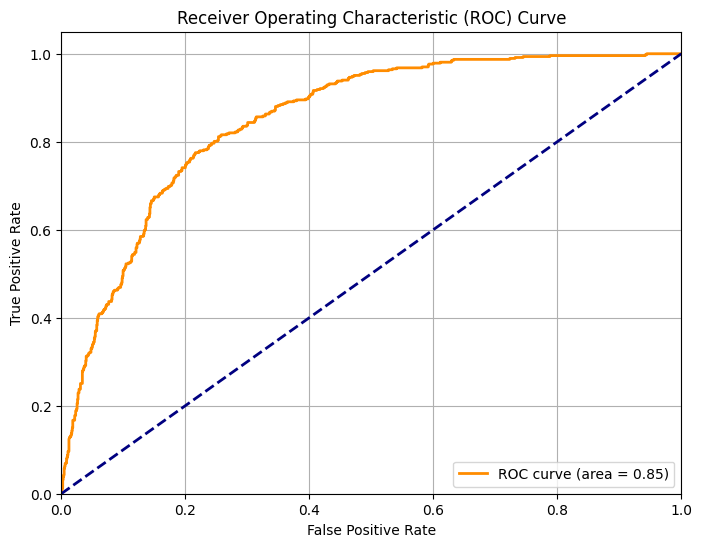

Avaliação do modelo final concluída.


In [13]:
from sklearn.metrics import roc_curve, auc

print("Avaliando o modelo final no conjunto de teste...")

# 1. Obter as probabilidades no conjunto de teste
final_model.eval()
with torch.no_grad():
    final_logits = final_model(X_test_num_t, X_test_cat_t)
    final_probs = torch.softmax(final_logits, 1)[:, 1].cpu().numpy()

# 2. Calcular a curva ROC e a AUC
fpr, tpr, thresholds = roc_curve(y_test_np, final_probs)
final_auc = auc(fpr, tpr)

print(f"AUC do modelo final no teste: {final_auc:.4f}")

# 3. Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {final_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("Avaliação do modelo final concluída.")

Gerando o gráfico KS para o modelo final...


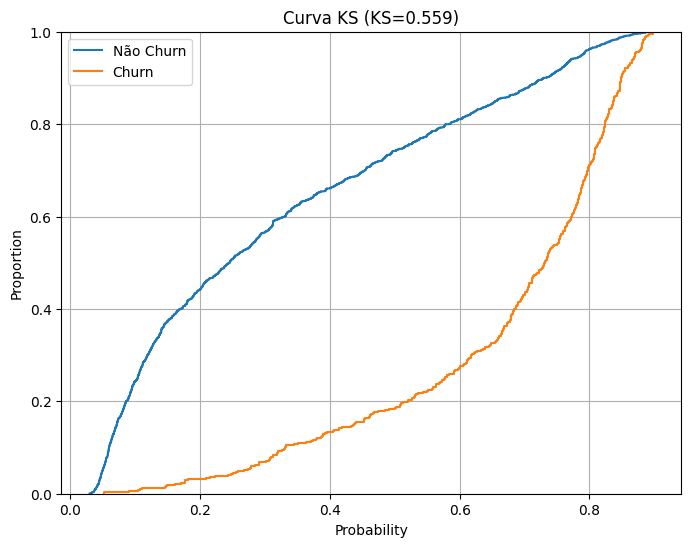

Gráfico KS gerado com sucesso.


In [14]:
print("Gerando o gráfico KS para o modelo final...")

# 1. Calcular o estatístico KS
ks_final = ks_2samp(final_probs[y_test_np == 0], final_probs[y_test_np == 1])[0]

# 2. Criar o gráfico ECDF
plt.figure(figsize=(8, 6))
sns.ecdfplot(final_probs[y_test_np == 0], label='Não Churn')
sns.ecdfplot(final_probs[y_test_np == 1], label='Churn')
plt.title(f'Curva KS (KS={ks_final:.3f})')
plt.xlabel('Probability')
plt.ylabel('Proportion')
plt.legend()
plt.grid(True)
plt.show()

print("Gráfico KS gerado com sucesso.")